### Importing Libraries

- Numpy and pandas for data preparation and handling.
- Matplotlib and seaborn for data visualization.
- Statmodels for statisticals methods and apis for decompositionss
- (auto) ARIMA and FBprophet for modelling and Results.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

sns.set_style('darkgrid')
%matplotlib inline

### Reading the Data

1. Reading data.
2. Convert date into pandas special datetime datatype.
3. Setting up index as date column for special features.

In [2]:
data = pd.read_csv('../input/electric-production/Electric_Production.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.rename(columns = {'DATE':'date'})
data = data.set_index('date')
data

,Value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


### Data Exploration

We can see that, the dataset has no missing values. 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


The data is ranging from 55.31 to 129.40 between 1988 to 2015.

In [4]:
data.describe()

,Value
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [5]:
data.isna().sum()

Value    0
dtype: int64

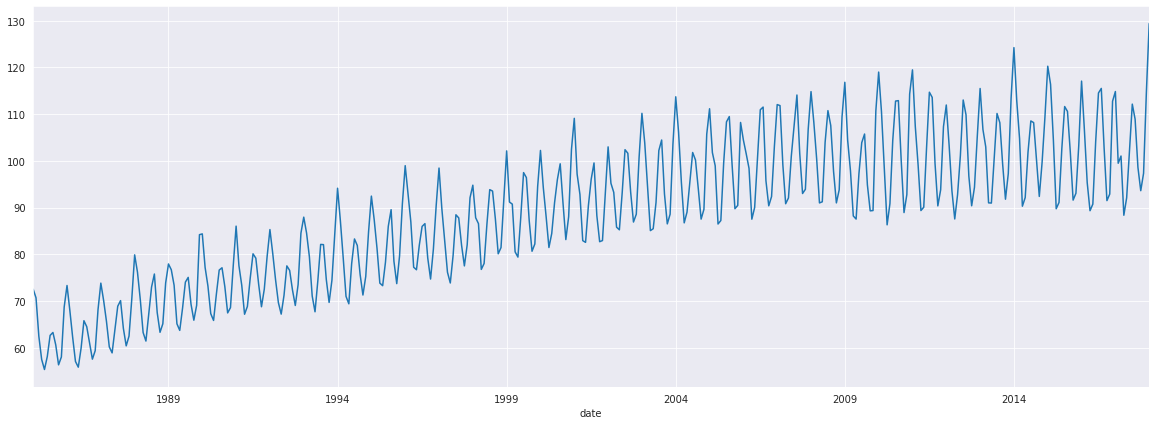

In [6]:
plt.figure(figsize = (20,7))
data['Value'].plot(kind = 'line')
plt.show()

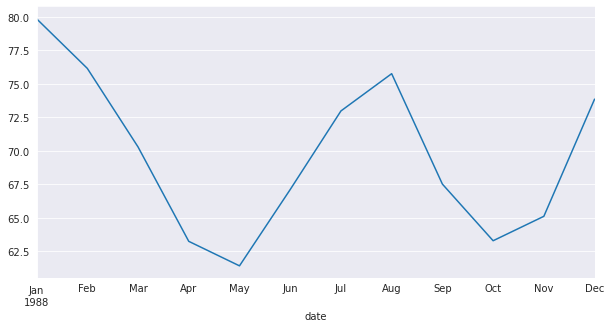

In [7]:
plt.figure(figsize = (10,5))
data['1988':'1988'].resample('m').mean()['Value'].plot(kind = 'line')
plt.show()

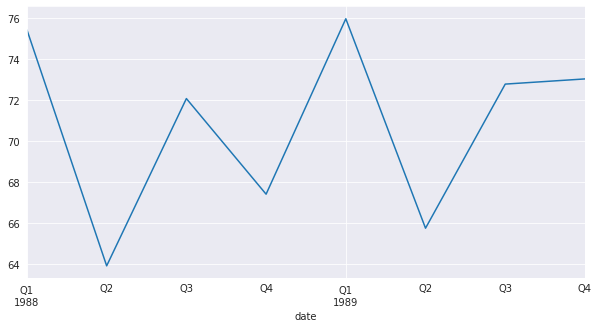

In [8]:
plt.figure(figsize = (10,5))
data['1988':'1989'].resample('q').mean()['Value'].plot(kind = 'line')
plt.show()

### Check for Stationary

**Augmented Dickey–Fuller test (ADF)** is a statistical test for finding whether the series is stationary or not.

**Null hypothesis** - Non Stationarity exists in the series.<br>
**Alternative Hypothesis** - Stationarity exists in the series.

The test also gives **P** value. (0<= p <=1).

If the p-value is **greater that 0.05 or 5%** then, the null hypothesis cannot be rejected. Therefore, the series is **not stationary**.<br>
Else, we can reject the hypothesis and conclude that the series is stationary.

In [9]:
adftest = adfuller(data['Value'])
adftest

(-2.2569903500472366,
 0.18621469116587053,
 15,
 381,
 {'1%': -3.4476305904172904,
  '5%': -2.869155980820355,
  '10%': -2.570827146203181},
 1840.8474501627156)

Here, we can see that the series is not stationary. <br>
However, the many time series model like ARMA requires time series to be stationary. <br>
Therefore, transformation is required before modelling.

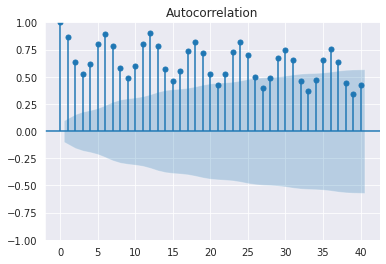

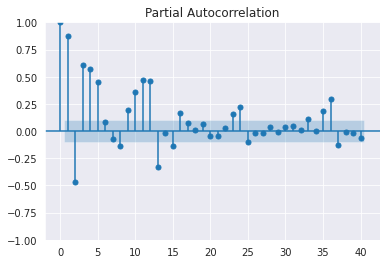

In [10]:
acf = plot_acf(data,lags=40)
pacf = plot_pacf(data,lags=40, method='ols')

### Converting the series into stationary series

Data transformation using LOG and differencing between y(n) - y(n-1)

In [11]:
temp = pd.DataFrame(np.log(data['Value']))

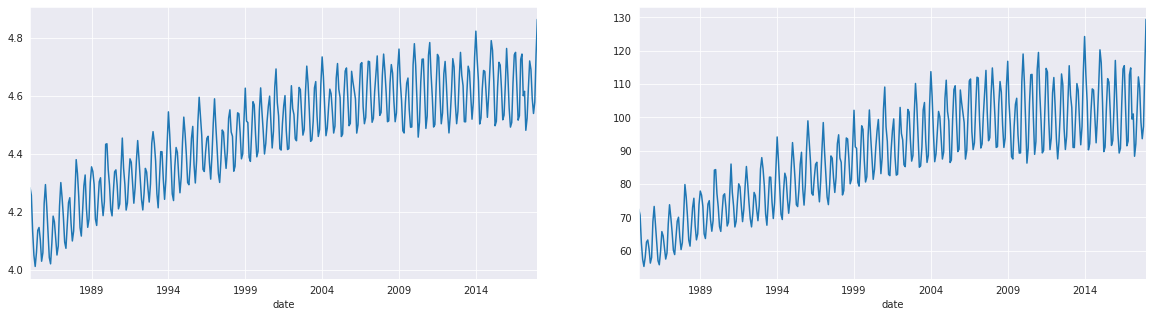

In [12]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
temp['Value'].plot(kind = 'line')
plt.subplot(1,2,2)
data['Value'].plot(kind = 'line')
plt.show()

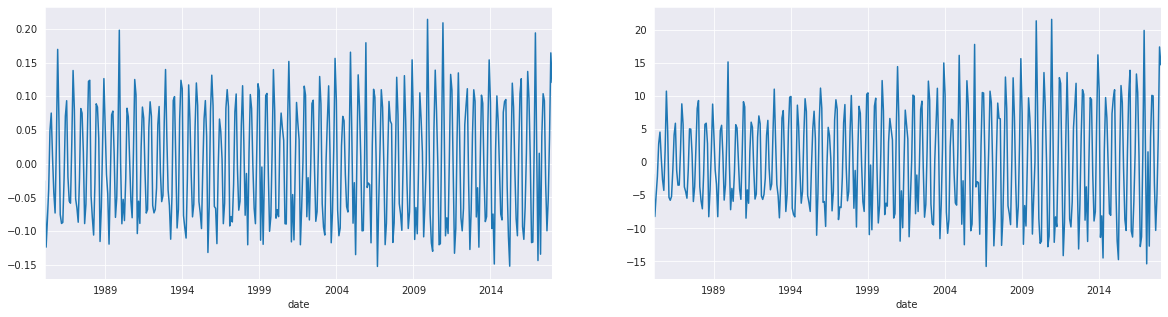

In [13]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
temp['Value'].diff(1).dropna().plot()
plt.subplot(1,2,2)
data['Value'].diff(1).dropna().plot()
plt.show()

The KPSS test follows **opposite hypothesis** than of Adfuller. (It is just an alternative test to Adfuller. Both can be used interchangably.)

In [14]:
kptest = kpss(temp['Value'].diff(1).dropna(),'c')
kptest

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2016: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.11412038097885754,
 0.1,
 34,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

This shows that the data is now stationary and ready for modelling.

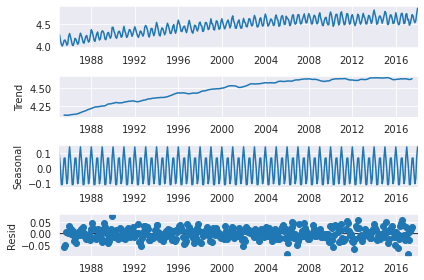

In [15]:
add_plot = sm.tsa.seasonal_decompose(temp,model = 'additive')
add_plot = add_plot.plot()

### Using ARIMA (ML)

Now, instead for manually modelling the transformed data,I prefer to use Auto ARIMA for now. <br>
Pmdarima is a library which is like AutoML for time series. It can help for automatically selecting the parameters (using grid search) rather than finding it with ACF anf PACF plots.

### Installing auto arima

In [16]:
!pip install -q pmdarima

In [17]:
import pmdarima as pm

model = pm.auto_arima(data, seasonal = True, d = 1, D = 1,m = 4,test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=inf, Time=2.08 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=3124.914, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=2946.068, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=3055.339, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=inf, Time=0.84 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=2057.069, Time=1.09 sec
 ARIMA(1,1,0)(2,1,2)[4]             : AIC=2050.826, Time=2.40 sec
 ARIMA(1,1,0)(1,1,2)[4]             : AIC=inf, Time=1.82 sec
 ARIMA(0,1,0)(2,1,2)[4]             : AIC=2064.558, Time=0.59 sec
 ARIMA(2,1,0)(2,1,2)[4]             : AIC=2000.791, Time=1.58 sec
 ARIMA(2,1,0)(1,1,2)[4]             : AIC=inf, Time=1.79 sec
 ARIMA(2,1,0)(2,1,1)[4]             : AIC=2010.148, Time=1.01 sec
 A

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  397
Model:             SARIMAX(3, 1, 0)x(2, 1, [1, 2], 4)   Log Likelihood                -982.565
Date:                                Wed, 09 Feb 2022   AIC                           1981.131
Time:                                        10:13:39   BIC                           2012.901
Sample:                                             0   HQIC                          1993.722
                                                - 397                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4759      0.046    -10.284      0.000      -0.567      -0.385
ar.L2         -0.4986      0.047    -10.634      0.000      -0.591      -0.407
ar.L3         -0.3371      0.058     -5.858      0.000      -0.450      -0.224
ar.S.L4       -0.9725      0.020    -47.754      0.000      -1.012      -0.933
ar.S.L8       -0.9447      0.017    -56.689      0.000      -0.977      -0.912
ma.S.L4       -0.5919      0.063     -9.348      0.000      -0.716      -0.468
ma.S.L8       -0.2565      0.055     -4.676      0.000      -0.364      -0.149
sigma2         8.2082      0.442     18.586      0.000       7.343       9.074
===================================================================================
Ljung-Box (L1) (Q):                   1.44   Jarque-Bera (JB):                56.22
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

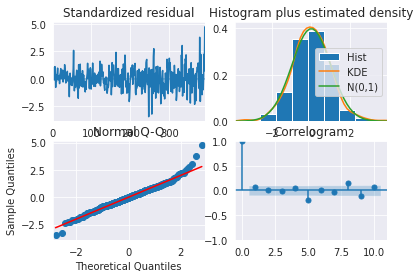

In [19]:
output = model.plot_diagnostics()

In [20]:
from pmdarima.model_selection import train_test_split
train,test = train_test_split(data,test_size = 0.1)

### Predictions

In [21]:
prediction = pd.DataFrame(model.predict(n_periods = int(test.size)), test.index)
prediction.columns = ["Prediction"]
test["Prediction"] = prediction

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


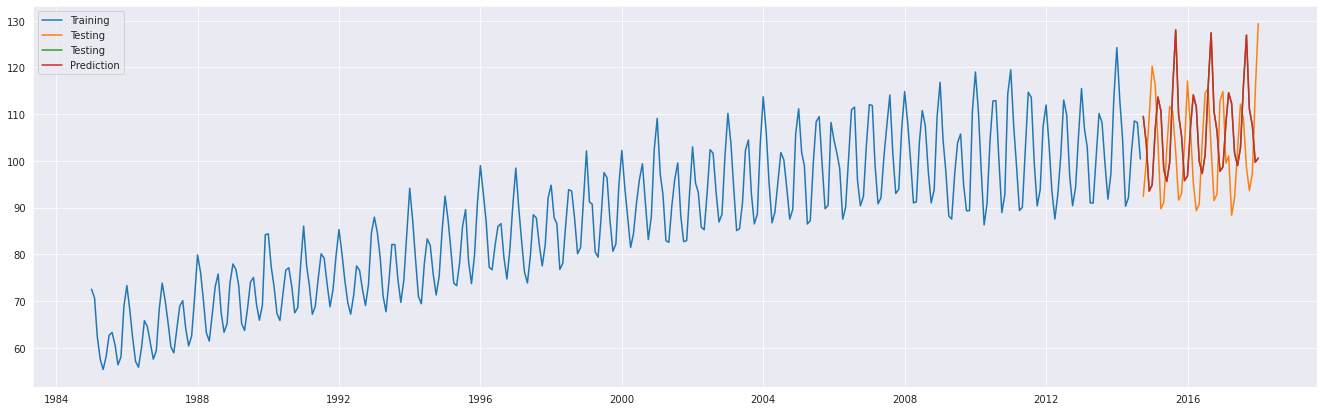

In [22]:
plt.figure(figsize = (23,7))
plt.plot(train, label = "Training")
plt.plot(test, label = "Testing")
plt.plot(prediction, label = "Prediction")
plt.legend()

In [23]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(months = x) for x in range(0,24)]

In [24]:
future_date_df = pd.DataFrame(index = future_dates[1:],columns = data.columns)

In [25]:
future_date_df["forecast"] = model.predict(n_periods = int(future_date_df.size),dynamic  = True )

<AxesSubplot:>

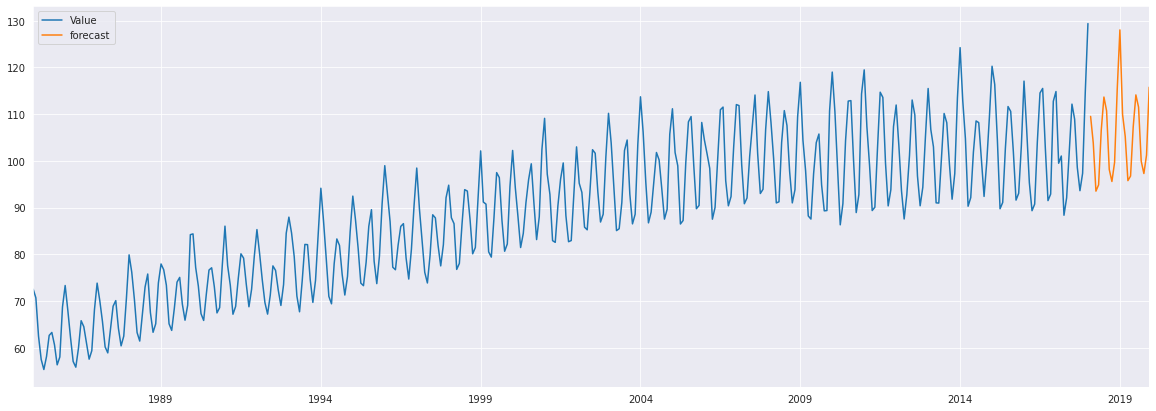

In [26]:
future_df = pd.concat([data,future_date_df])
future_df.plot(figsize = (20,7))

### Facebook Prophet (ML)

### Installing fbprophet

In [27]:
!pip install -q prophet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [28]:
from prophet.plot import plot_plotly
from fbprophet import Prophet

In [29]:
fb_data = data.reset_index().rename(columns = {'date':'ds', 'Value':'y'})

In [30]:
train,test = train_test_split(fb_data,test_size = 0.1)

### fbprophet (ML)

In [31]:
m = Prophet(interval_width=0.95)
m.fit(train)
future = m.make_future_dataframe(periods= int(test.shape[0]), freq = 'M')
forecast = m.predict(future)

Initial log joint probability = -2.9968
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1180.15    0.00820877       499.117           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1182.6    0.00526571        100.08      0.6205      0.6205      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       1183.13   0.000123257       147.937   1.049e-06       0.001      359  LS failed, Hessian reset 
     299       1183.62   7.73417e-05       78.6757      0.2994           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       1183.62   5.90217e-08        63.395      0.2641           1      517   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


### Prediction

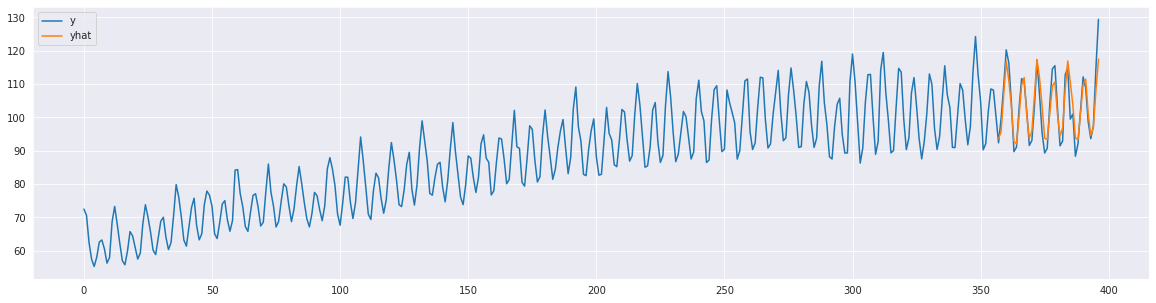

In [32]:
fb_data['y'].plot(kind = 'line')
forecast[int(forecast.shape[0])- int(test.shape[0]):]['yhat'].plot(kind = 'line', figsize = (20,5))
plt.legend()
plt.show()

In [33]:
plot_plotly(m ,forecast)

### Forecast using fbprophet

In [34]:
m_all = Prophet(interval_width=0.95)
m_all.fit(fb_data)
future = m_all.make_future_dataframe(periods= 24, freq = 'M')
forecast = m_all.predict(future)

Initial log joint probability = -4.76034
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1303.77    0.00148991       118.606       2.212      0.2212      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1304.86   5.98171e-05       70.4298       0.438           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       1304.94   0.000639245       150.966   8.661e-06       0.001      313  LS failed, Hessian reset 
     243       1305.03    1.1725e-05       62.9042   1.699e-07       0.001      393  LS failed, Hessian reset 
     285       1305.04   4.95678e-05        94.757    7.73e-07       0.001      488  LS failed, Hessian reset 
     299       1305.04   2.83172e-07       47.6234       0.329           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

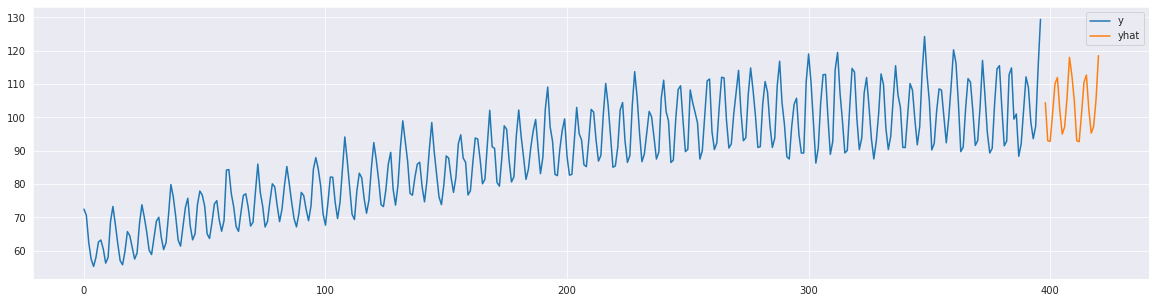

In [35]:
fb_data['y'].plot(kind = 'line')
forecast[-(int(forecast.shape[0])-int(fb_data.shape[0]))+1:]['yhat'].plot(kind = 'line', figsize = (20,5))
plt.legend()
plt.show()